In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import torch
import collections

## Stage distribution and data preparation (Mild:0, Moderate:1, Severe:2, Recovery:3)

In [3]:
#data = pd.read_csv('/Users/muzheguo/Desktop/GWU/Group/MyPaper/KDD/hrv-covid19/cleaned_data/merged_sur_hrv_hr.csv') 
#rrdata = pd.read_csv('/Users/muzheguo/Desktop/GWU/Group/MyPaper/KDD/hrv-covid19/cleaned_data/rrdata.csv')
from google.colab import files
uploaded = files.upload()  #merged_sur_hrv_hr.csv  and  rrdata.csv

Saving merged_sur_hrv_hr.csv to merged_sur_hrv_hr.csv


In [4]:
rrdata = pd.read_csv('rrdata.csv')
data = pd.read_csv('merged_sur_hrv_hr.csv')
onehot_time = pd.get_dummies(data.time_of_day, prefix='OneHot')
data = data.drop(['time_of_day'], axis=1 )
data = pd.concat([onehot_time, data],axis=1) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


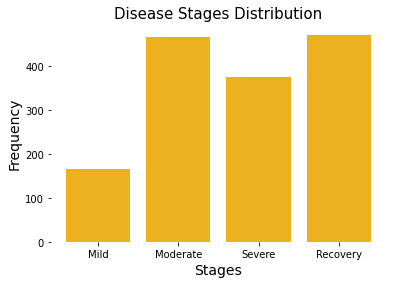

In [5]:
classList = list(data['class4'])
freq = [classList.count(0),classList.count(1),classList.count(2),classList.count(3)]
plt.bar(['Mild','Moderate','Severe','Recovery'], freq, align='center',facecolor='#EDB120')
plt.title('Disease Stages Distribution',fontsize =15)
plt.ylabel('Frequency',fontsize =14)
plt.xlabel('Stages',fontsize =14)
ax1 = plt.axes()
ax1.set_frame_on(False)

In [6]:
data1 = data[['OneHot_day', 'OneHot_evening','OneHot_morning','OneHot_night','bpm', 'meanrr', 'mxdmn', 'sdnn',
       'rmssd', 'pnn50', 'mode', 'amo', 'lf', 'hf', 'vlf', 'lfhf',
       'total_power', 'day_after_test', 'S_COVID_BREATH', 'S_COVID_CONFUSION',
       'S_COVID_COUGH', 'S_COVID_FATIGUE', 'S_COVID_FEVER', 'S_COVID_PAIN',
       'S_COVID_BLUISH', 'class4']] 

In [7]:
from scipy.stats import iqr

N, T, C= 1480, 100, 4

##Point Features:
rr_features = pd.DataFrame({'rr_var' : []}) 
#Variance: the average of the squared differences from the mean
rr_features['rr_var'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).var(axis=1)
#Skewness, a measure of symmetry:
rr_features['rr_skew'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).skew(axis=1)
#Kurtosis: How heavily the tails of a distribution differ from the tails of a normal distribution:
rr_features['rr_kurt'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).kurtosis(axis=1)
#Max: 
rr_features['rr_max'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).max(axis=1)
#Min: 
rr_features['rr_min'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).min(axis=1)
#Median:
rr_features['rr_median'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).median(axis=1)
#Interquartile range (IQR):  the difference between the 75th and 25th percentile of the data.
rr_features['rr_IQR'] = iqr(rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1),axis=1)

ori_point_features = data1.drop(['class4'], axis=1) #original point features
Pointdata = torch.tensor(pd.concat([ori_point_features, rr_features],axis=1).values).to(torch.float) #(1480, 25)
Pointdata = (Pointdata-Pointdata.min(0, keepdim=True).values)/(Pointdata.max(0, keepdim=True).values - Pointdata.min(0, keepdim=True).values) #Rescale 


##Sequence Features:  
#rr_diff: Difference
rr_diff = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).diff(periods=-1, axis=1)*(-1) 
rr_diff['rr99'] = 1/3*(rr_diff['rr98'] + rr_diff['rr97'] + rr_diff['rr96'])
rr_diff_tensor = torch.tensor(rr_diff.values).to(torch.float)
rr_diff_tensor = (rr_diff_tensor-rr_diff_tensor.min(0, keepdim=True).values)/(rr_diff_tensor.max(0, keepdim=True).values - rr_diff_tensor.min(0, keepdim=True).values) #Rescale 
rr_diff_tensor = rr_diff_tensor.reshape(N,T,1)
#rr_AbsMeanDiff = Absolute Different from the mean:
rr_AbsMeanDiff = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1)
rr_AbsMeanDiff = abs(rr_AbsMeanDiff-rr_AbsMeanDiff.mean(0).values)
rr_AbsMeanDiff_tensor = torch.tensor(rr_AbsMeanDiff.values).to(torch.float)
rr_AbsMeanDiff_tensor = (rr_AbsMeanDiff_tensor-rr_AbsMeanDiff_tensor.min(0, keepdim=True).values)/(rr_AbsMeanDiff_tensor.max(0, keepdim=True).values - rr_AbsMeanDiff_tensor.min(0, keepdim=True).values) #Rescale 
rr_AbsMeanDiff_tensor = rr_AbsMeanDiff_tensor.reshape(N,T,1)
#Original seq features
rr = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1) #original seq features
rr_tensor = torch.tensor(rr.values).to(torch.float)
rr_tensor = (rr_tensor-rr_tensor.min(0, keepdim=True).values)/(rr_tensor.max(0, keepdim=True).values - rr_tensor.min(0, keepdim=True).values) #Rescale 
rr_tensor = rr_tensor.reshape(N,T,1)
#Combine
Seqdata = torch.cat((rr_tensor, rr_diff_tensor, rr_AbsMeanDiff_tensor), 2) #(1480, 100, 2)


##Class label:  
class_y = torch.tensor(data1['class4'].values)  #(N=1480, )

print("Pointdata:", Pointdata.shape, Pointdata.dtype)
print("Seqdata:", Seqdata.shape, Seqdata.dtype)
print("class_y:", class_y.shape, class_y.dtype)


Pointdata: torch.Size([1480, 32]) torch.float32
Seqdata: torch.Size([1480, 100, 3]) torch.float32
class_y: torch.Size([1480]) torch.int64


## K-fold data

In [8]:
from sklearn.model_selection import KFold
import random

KFold_data = {'trainPX':[], 'testPX':[], 'trainSX':[], 'testSX':[], 'trainY':[], 'testY':[]}
n_splits = 5
kf = KFold(n_splits = n_splits, shuffle=True, random_state = 2022)
for train_index, test_index in kf.split(Pointdata):
    random.seed(2022)
    random.shuffle(train_index)
    random.shuffle(test_index)
    KFold_data['trainPX'].append( Pointdata[train_index] )
    KFold_data['testPX'].append( Pointdata[test_index] )
    KFold_data['trainSX'].append( Seqdata[train_index] )
    KFold_data['testSX'].append( Seqdata[test_index] )
    KFold_data['trainY'].append( class_y[train_index] )
    KFold_data['testY'].append( class_y[test_index] )
train_size =  KFold_data['trainPX'][0].shape[0]   #training data size
print("Point training data :", KFold_data['trainPX'][0].shape)
print("Point test data :", KFold_data['testPX'][0].shape)
print("Sequence training data :", KFold_data['trainSX'][0].shape)
print("Sequence test data :", KFold_data['testSX'][0].shape)
print("training labels:", KFold_data['trainY'][0].shape)
print("test labels:", KFold_data['testY'][0].shape)

Point training data : torch.Size([1184, 32])
Point test data : torch.Size([296, 32])
Sequence training data : torch.Size([1184, 100, 3])
Sequence test data : torch.Size([296, 100, 3])
training labels: torch.Size([1184])
test labels: torch.Size([296])


## metric methods and multiclass ROC function 

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_auc_score, auc, roc_curve
import seaborn as sn

In [10]:
from sklearn import preprocessing
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

## Machine learning methods

### Method 1:  KNN

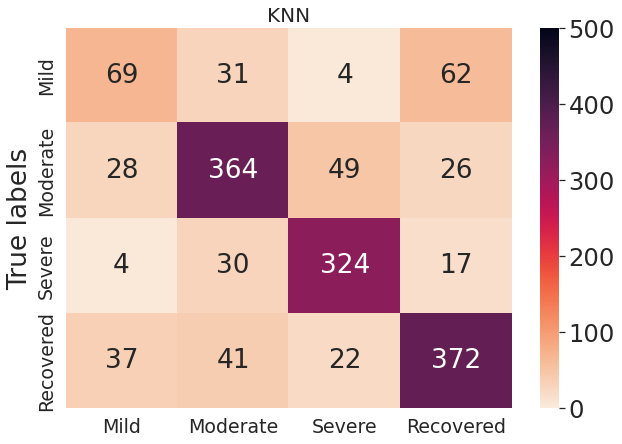

accuracy_score 0.763
precision_score 0.761
recall_score 0.763
f1_score 0.759
Multi_auc 0.816


In [11]:
from sklearn.neighbors import KNeighborsClassifier

conf_Matrix_knn = np.zeros((4,4),dtype=int) 
accuracy_knn, precision_knn, recall_knn, f1_knn, Multi_auc_knn = 0.,0.,0.,0.,0.

for k in range(n_splits):
    knnclassifier = KNeighborsClassifier(n_neighbors=5)
    knnclassifier = knnclassifier.fit(KFold_data['trainPX'][k], KFold_data['trainY'][k])
    y_pred_knn = knnclassifier.predict(KFold_data['testPX'][k])
    conf_Matrix_knn += confusion_matrix(KFold_data['testY'][k], y_pred_knn)
    
    accuracy_knn += accuracy_score(np.array(KFold_data['testY'][k]), y_pred_knn)/n_splits 
    precision_knn += precision_score(np.array(KFold_data['testY'][k]), y_pred_knn, average='weighted')/n_splits  
    recall_knn += recall_score(np.array(KFold_data['testY'][k]), y_pred_knn, average='weighted')/n_splits 
    f1_knn += f1_score(np.array(KFold_data['testY'][k]), y_pred_knn, average='weighted')/n_splits  
    Multi_auc_knn += multiclass_roc_auc_score(np.array(KFold_data['testY'][k]),y_pred_knn)/n_splits 

sn.set(font_scale=2.2)
plt.figure(figsize = (10,7))
heatmap = sn.heatmap(conf_Matrix_knn, annot=True, cmap='rocket_r',xticklabels=['Mild','Moderate','Severe','Recovered'],
                     yticklabels=['Mild','Moderate','Severe','Recovered'],vmin=0, vmax=500,fmt="d")
plt.title('KNN', fontsize=20)
plt.ylabel("True labels") 
plt.yticks(rotation=90,fontsize=19)
plt.xticks(fontsize=19)
plt.show()

print("accuracy_score",round(accuracy_knn,3))
print("precision_score", round(precision_knn,3))
print("recall_score", round(recall_knn,3))
print("f1_score", round(f1_knn,3))
print("Multi_auc",round(Multi_auc_knn,3))

### Method 2: Logistic

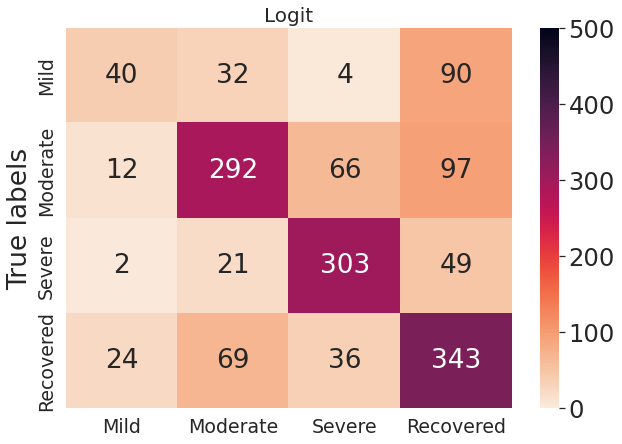

accuracy_score 0.661
precision_score 0.666
recall_score 0.661
f1_score 0.65
Multi_auc 0.741


In [15]:
from sklearn.linear_model import LogisticRegression

conf_Matrix_logis = np.zeros((4,4),dtype=int) 
accuracy_logis, precision_logis, recall_logis, f1_logis, Multi_auc_logis = 0.,0.,0.,0.,0.
for k in range(n_splits): 
    lgcclassifier = LogisticRegression(multi_class='multinomial',solver ='newton-cg')
    lgcclassifier.fit(KFold_data['trainPX'][k], KFold_data['trainY'][k])
    
    y_pred_logis = lgcclassifier.predict(KFold_data['testPX'][k])
    conf_Matrix_logis += confusion_matrix(KFold_data['testY'][k], y_pred_logis)
    
    accuracy_logis += accuracy_score(np.array(KFold_data['testY'][k]), y_pred_logis)/n_splits 
    precision_logis += precision_score(np.array(KFold_data['testY'][k]), y_pred_logis, average='weighted')/n_splits  
    recall_logis += recall_score(np.array(KFold_data['testY'][k]), y_pred_logis, average='weighted')/n_splits 
    f1_logis += f1_score(np.array(KFold_data['testY'][k]), y_pred_logis, average='weighted')/n_splits  
    Multi_auc_logis += multiclass_roc_auc_score(np.array(KFold_data['testY'][k]),y_pred_logis)/n_splits 

sn.set(font_scale=2.2)
plt.figure(figsize = (10,7))
heatmap = sn.heatmap(conf_Matrix_logis, annot=True, cmap='rocket_r',xticklabels=['Mild','Moderate','Severe','Recovered'],
                     yticklabels=['Mild','Moderate','Severe','Recovered'],vmin=0, vmax=500,fmt="d")
plt.title('Logit', fontsize=20)
plt.ylabel("True labels") 
plt.yticks(rotation=90,fontsize=19)
plt.xticks(fontsize=19)
plt.show()

print("accuracy_score",round(accuracy_logis,3))
print("precision_score", round(precision_logis,3))
print("recall_score", round(recall_logis,3))
print("f1_score", round(f1_logis,3))
print("Multi_auc",round(Multi_auc_logis,3))

### Method 3: SVM

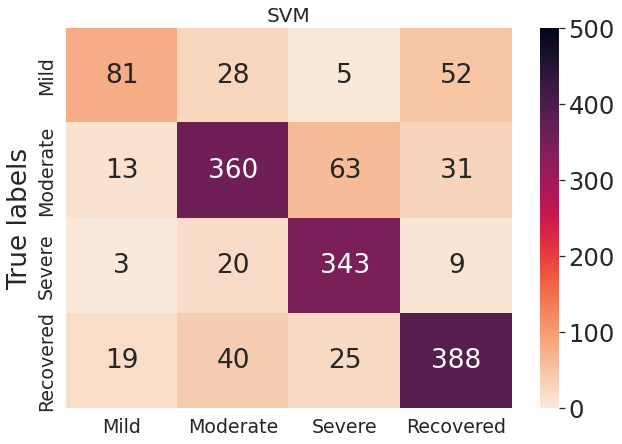

accuracy_score 0.792
precision_score 0.791
recall_score 0.792
f1_score 0.787
Multi_auc 0.839


In [13]:
from sklearn.svm import SVC

conf_Matrix_svm = np.zeros((4,4),dtype=int) 
accuracy_svm, precision_svm, recall_svm, f1_svm, Multi_auc_svm = 0.,0.,0.,0.,0.
for k in range(n_splits): 
    svclassifier = SVC(kernel='poly')  #‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
    svclassifier = svclassifier.fit(KFold_data['trainPX'][k], KFold_data['trainY'][k])
    
    y_pred_svm = svclassifier.predict(KFold_data['testPX'][k])
    conf_Matrix_svm += confusion_matrix(KFold_data['testY'][k], y_pred_svm)
    
    accuracy_svm += accuracy_score(np.array(KFold_data['testY'][k]), y_pred_svm)/n_splits 
    precision_svm += precision_score(np.array(KFold_data['testY'][k]), y_pred_svm, average='weighted')/n_splits  
    recall_svm += recall_score(np.array(KFold_data['testY'][k]), y_pred_svm, average='weighted')/n_splits 
    f1_svm += f1_score(np.array(KFold_data['testY'][k]), y_pred_svm, average='weighted')/n_splits  
    Multi_auc_svm += multiclass_roc_auc_score(np.array(KFold_data['testY'][k]),y_pred_svm)/n_splits 

sn.set(font_scale=2.2)
plt.figure(figsize = (10,7))
heatmap = sn.heatmap(conf_Matrix_svm, annot=True, cmap='rocket_r',xticklabels=['Mild','Moderate','Severe','Recovered'],
                     yticklabels=['Mild','Moderate','Severe','Recovered'],vmin=0, vmax=500,fmt="d")
plt.title('SVM', fontsize=20)
plt.ylabel("True labels") 
plt.yticks(rotation=90,fontsize=19)
plt.xticks(fontsize=19)
plt.show()

print("accuracy_score",round(accuracy_svm,3))
print("precision_score", round(precision_svm,3))
print("recall_score", round(recall_svm,3))
print("f1_score", round(f1_svm,3))
print("Multi_auc",round(Multi_auc_svm,3))

## Deep learning methods 

In [ ]:
#coutils package
!pip install git+https://github.com/Mooozer/starterCode_-fromJohnson
import coutils
from coutils import fix_random_seed

  Cloning https://github.com/Mooozer/starterCode_-fromJohnson to /tmp/pip-req-build-otluae2v
  Running command git clone -q https://github.com/Mooozer/starterCode_-fromJohnson /tmp/pip-req-build-otluae2v
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-py3-none-any.whl size=10307 sha256=34c64658c27864569f2819dd206a3dc171368090649d30251c557701dce041c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-kp_esqg1/wheels/26/bc/a7/8262fb80fdb4423f53fd1042948b03aae3f09d1a69b16f3ec5
Successfully built Colab-Utils


In [ ]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import seaborn as sn

if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


In [ ]:
# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

### LSTM 

In [ ]:
def lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b, attn=None, Wattn=None):
    """
    Forward pass for a single timestep of an LSTM.

    The input data has dimension D(number of sequences is D), the hidden state has dimension H=1, and we use
    a minibatch size of N.

    Inputs:
    - x: Input data, of shape (N, D)
    - prev_h: Previous hidden state, of shape (N, H=1)
    - prev_c: previous cell state, of shape (N, H=1)
    - Wx: Input-to-hidden weights, of shape (D, 4H=4)
    - Wh: Hidden-to-hidden weights, of shape (H=1, 4H=4)
    - b: Biases, of shape (4H=4,)      
    
    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - next_c: Next cell state, of shape (N, H)
    """
    next_h, next_c = None, None
    N,D = x.shape 
    N,H = prev_h.shape
    A = x.mm(Wx) +  prev_h.mm(Wh)  + b 
    a_i , a_f, a_o, a_g =  A[:,0:H], A[:,H:2*H], A[:,2*H:3*H], A[:,3*H:4*H]
    i, f, o, g = torch.sigmoid(a_i),torch.sigmoid(a_f),torch.sigmoid(a_o), torch.tanh(a_g)
    next_c = f * prev_c + i * g 
    next_h = o * torch.tanh(next_c)
    return next_h, next_c

In [ ]:
def lstm_forward(x, h0, Wx, Wh, b, outT):
    """
    Forward pass for an LSTM over an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The LSTM uses a hidden
    size of H=1, and we work over a minibatch containing N sequences. After running
    the LSTM forward, we return the hidden states for all timesteps.

    Inputs:
    - x: Input data, of shape (N, T, D)
    - h0: Initial hidden state, of shape (N, D)
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H=4)
    - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H=4)
    - b: Biases, of shape (4H=4,)
    - outT: how many timesteps returned of the hidden states

    Returns a tuple of:
    - h: Hidden states for all timesteps of all sequences, of shape (N, T, H=1)
    """
    h = None
    c0 = torch.zeros_like(h0) #the intial cell state c0 
    N, T, D = x.shape
    H = Wh.shape[0]
    h = torch.zeros(N, T, H , **to_float_cuda)
    prev_h = h0
    prev_c = c0 
    for t in range(T):
      A = x[:, t, :].mm(Wx) +  prev_h.mm(Wh) + b 
      a_i , a_f, a_o, a_g =  A[:,0:H], A[:,H:2*H], A[:,2*H:3*H], A[:,3*H:4*H]
      i, f, o, g = torch.sigmoid(a_i), torch.sigmoid(a_f), torch.sigmoid(a_o), torch.tanh(a_g)
      next_c = f * prev_c + i * g 
      next_h = o * torch.tanh(next_c)
      h[:, t, :] = next_h        
      prev_h, prev_c = next_h , next_c
    outIndex = [int(i) for i in np.linspace(0,100,num=outT+1,endpoint=False,retstep=True)[0][1:]] #len = outT
    h = h[:, outIndex, :]  #(N, outT, H)
    return h

In [ ]:
def softmax_loss(x, y):
    """
    Inputs:
    - x: Input scores, of shape (N, C=4) 
    - y: Ground-truth indices, of shape (N, ) where each element is in the range 1 <= y[i] <= 4

    Returns:
    - loss: Scalar giving loss
    """
    loss = None    
    N, C = x.shape[0], x.shape[1]  
    loss = F.cross_entropy(x, y, reduction='sum') * 1. / N   
    return loss

### LSTM-DNN

In [ ]:
class RNN_DNN(nn.Module):
    def __init__(self, input_dim=1, input_dim_v=4, input_dim_t=100, C=4, hidden_dim=1, proj_dim=1, 
                 DNN_hidden_Size=[10,5], reg=0.0, cell_type='lstm', dropratio=0.5, device='cuda', dtype=torch.float):
        """
        Inputs:
        - input_dim: Dimension D of input(number of sequence) 
        - input_dim_v: number of point features
        - input_dim_t: length of time for sequence features 
        - C: number of classes 
        - hidden_dim: Dimension H for the hidden state of the RNN.
        - DNN_hidden_Size: list, dimension of DNN hidden layers
        - reg: regularization parameter
        - cell_type: What type of RNN to use: 'lstm'
        - device: 'cuda' or 'cpu'
        - dtype: datatype to use
        """
        super().__init__()
        if cell_type not in {'rnn', 'lstm'}:
            raise ValueError('Invalid cell_type "%s"' % cell_type)
        
        self.input_dim = input_dim
        self.H = hidden_dim
        self.V = input_dim_v
        self.T = input_dim_t
        self.C = C 
        self.P = proj_dim
        self.DNN_hidden_Size = DNN_hidden_Size
        self.dtype = dtype
        self.device = device
        self.cell_type = cell_type
        self.reg = reg 
        self.dropratio = dropratio

        # Initialize parameters for the RNN / LSTM  
        fac = {'rnn':1, 'lstm':4}[self.cell_type]
        self.Wx = Parameter(torch.randn(input_dim, fac * self.H, device=device, dtype=dtype).div(math.sqrt(input_dim)))
        self.Wh = Parameter(torch.randn(self.H, fac * self.H, device=device, dtype=dtype).div(math.sqrt(self.H)))
        self.b = Parameter(torch.zeros(fac * self.H, device=device, dtype=dtype))

        #Initialize RNN output multi-state(N,T,H=1) -> single state(N,H=1) projection parameters: 
        self.W_proj = Parameter(torch.randn(self.T, self.P, device=device, dtype=dtype).div(math.sqrt(input_dim)))
        self.b_proj = Parameter(torch.zeros(self.P, device=device, dtype=dtype))

        #Initialize parameters for DNN 
        W_d1 = Parameter(torch.randn(self.V+self.P, self.DNN_hidden_Size[0], device=device, dtype=dtype).div(math.sqrt(self.V + self.P)))
        exec(f'self.W_d{1} = W_d1') 
        b_d1 = Parameter(torch.zeros(self.DNN_hidden_Size[0], device=device, dtype=dtype))
        exec(f'self.b_d{1} = b_d1') 
        for i in range(2,len(self.DNN_hidden_Size)+1):
          W_di = Parameter(torch.randn(self.DNN_hidden_Size[i-2], self.DNN_hidden_Size[i-1], device=device, dtype=dtype).div(math.sqrt(self.DNN_hidden_Size[i-2])))
          exec(f'self.W_d{i} = W_di')   
          b_di = Parameter(torch.zeros(self.DNN_hidden_Size[i-1], device=device, dtype=dtype)) 
          exec(f'self.b_d{i} = b_di')   
        W_dlast = Parameter(torch.randn(self.DNN_hidden_Size[-1], self.C, device=device, dtype=dtype).div(math.sqrt(self.DNN_hidden_Size[-1])))
        exec(f'self.W_d{len(self.DNN_hidden_Size)+1} = W_dlast')   
        b_dlast = Parameter(torch.zeros(self.C, device=device, dtype=dtype))
        exec(f'self.b_d{len(self.DNN_hidden_Size)+1} = b_dlast')   
 
    
    def train_process(self):
      raise NotImplementedError
    
    def test_process(self):
      raise NotImplementedError
    
    def UQ_test_process(self):
      raise NotImplementedError


In [ ]:
    def RNN_DNN_forward(self, Pointdata, Seqdata, y):
        """
        Inputs:
        - Pointdata: (N, V) 
        - Seqdata: (N, T, D)
        - y: (N,)

        Outputs:
        - loss: A scalar loss
        """

        loss = 0.0
        Pointdata = Pointdata.to(self.device)  #(N,V)
        Seqdata = Seqdata.to(self.device)
        groundTruth_y = y.to(torch.long).to(self.device) #(N,)

        #(1) h0
        A0 = Seqdata[:,0,:].mm(self.Wx) #(N,4H)
        h0 =  A0[:,0:self.H] + A0[:,self.H:2*self.H] + A0[:,2*self.H:3*self.H] + A0[:,3*self.H:4*self.H]


        #(2) multi-state(hidden state)
        if self.cell_type == 'lstm':
          hidden_state = lstm_forward(Seqdata, h0, self.Wx, self.Wh, self.b, self.T)   #(N,T,H=1) 

        N = Pointdata.shape[0]
        H = self.H
        T = self.T

        #(3) single state 
        single_state = hidden_state.reshape(N, T*H).mm(self.W_proj)+self.b_proj  #(N,P)  
        single_state = F.dropout(single_state, p=self.dropratio) 

        #(4) DNN 
        DNNInput = torch.cat((Pointdata, single_state), 1)  #(N, V+P)
      
        # if only consider Series data:
        if self.V == 0:
          DNNInput = single_state  #(N, P)
        # if only consider Point data:
        if self.P == 0:
          DNNInput = Pointdata #(N, V) 

        DNNhidden = DNNInput.mm(self.W_d1)+self.b_d1  
        DNNhidden = torch.sigmoid(DNNhidden)
        DNNhidden = F.dropout(DNNhidden, p=self.dropratio)
        for i in range(2,len(self.DNN_hidden_Size)+1):
          DNNhidden = DNNhidden.mm(eval('self.W_d'+str(i))) + eval('self.b_d'+str(i))
          DNNhidden = F.leaky_relu(DNNhidden, negative_slope=0.01) # DNNhidden = torch.relu(DNNhidden)  #
          DNNhidden = F.dropout(DNNhidden, p=self.dropratio) 
        DNNoutput = DNNhidden.mm(eval('self.W_d'+str(len(self.DNN_hidden_Size)+1))) + eval('self.b_d'+str(len(self.DNN_hidden_Size)+1))  

        #(5)
        loss = softmax_loss(DNNoutput, groundTruth_y)
        loss +=self.reg * torch.sum(self.Wx*self.Wx) + self.reg * torch.sum(self.Wh*self.Wh) #regularization 
        loss +=self.reg * torch.sum(self.W_proj*self.W_proj) #regularization 
      
        return loss

    RNN_DNN.train_process = RNN_DNN_forward

In [ ]:
    def RNN_DNN_test(self, Pointdata, Seqdata, y_test):
        """
        Inputs:
        - Pointdata: (N, V) 
        - Seqdata: (N, T, D)

        Outputs:
        - scalar: classficition 
        """

        Pointdata = Pointdata.to(self.device)  #(N,V)
        Seqdata = Seqdata.to(self.device)
        groundTruth_y = y_test.to(torch.long).to(self.device) #(N,)
        #(1) h0
        A0 = Seqdata[:,0,:].mm(self.Wx) #(N,4H)
        h0 =  A0[:,0:self.H] + A0[:,self.H:2*self.H] + A0[:,2*self.H:3*self.H] + A0[:,3*self.H:4*self.H]

        #(2) multi-state(hidden state)
        if self.cell_type == 'lstm':
          hidden_state = lstm_forward(Seqdata, h0, self.Wx, self.Wh, self.b, self.T)   #(N,T,H=1) 
       
        N = Pointdata.shape[0]
        H = self.H 
        T = self.T
        
        #(3) single state 
        single_state = hidden_state.reshape(N, T*H).mm(self.W_proj)+self.b_proj  #(N,P)  

        #(4) DNN 
        DNNInput = torch.cat((Pointdata, single_state), 1)  #(N, V+P)

        # if only consider Series data:
        if self.V == 0:
          DNNInput = single_state  #(N, P)
        # if only consider Point data:
        if self.P == 0:
          DNNInput = Pointdata #(N, V) 


        DNNhidden = DNNInput.mm(self.W_d1)+self.b_d1  
        DNNhidden = torch.sigmoid(DNNhidden)
        for i in range(2,len(self.DNN_hidden_Size)+1):
          DNNhidden = DNNhidden.mm(eval('self.W_d'+str(i))) + eval('self.b_d'+str(i))
          DNNhidden = F.leaky_relu(DNNhidden, negative_slope=0.01)  #DNNhidden = torch.relu(DNNhidden) 
        DNNoutput = DNNhidden.mm(eval('self.W_d'+str(len(self.DNN_hidden_Size)+1))) + eval('self.b_d'+str(len(self.DNN_hidden_Size)+1))  
                
        #(5)
        pred_y = DNNoutput.argmax(dim=1)

        loss = softmax_loss(DNNoutput, groundTruth_y)
        loss +=self.reg * torch.sum(self.Wx*self.Wx) + self.reg * torch.sum(self.Wh*self.Wh) #regularization 
        loss +=self.reg * torch.sum(self.W_proj*self.W_proj) #regularization 

        return  pred_y, loss

    RNN_DNN.test_process = RNN_DNN_test

In [ ]:
def ModelTrain(rnndnn_model, Point_data, Seq_data, y_data, lr_decay=1, **kwargs):
  """
  Run optimization to train the model.
  """
  # optimizer setup
  from torch import optim
  optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, rnndnn_model.parameters()), learning_rate) # leave betas and eps by default
  lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: lr_decay ** epoch)

  # sample minibatch data
  iter_per_epoch = math.ceil(Point_data.shape[0] // batch_size)
  loss_history = []
  rnndnn_model.train()
  for i in range(num_epochs):
    start_t = time.time()
    for j in range(iter_per_epoch):
      PointData = Point_data[j*batch_size:(j+1)*batch_size]
      SeqData =  Seq_data[j*batch_size:(j+1)*batch_size]
      y = y_data[j*batch_size:(j+1)*batch_size]

      loss = rnndnn_model.train_process(PointData, SeqData, y)
      optimizer.zero_grad() 
      loss.backward()
      loss_history.append(loss.item())
      optimizer.step()
    end_t = time.time()
    if i%100 == 0:
      print('(Epoch {} / {}) loss: {:.4f} time per epoch: {:.1f}s'.format(i, num_epochs, loss.item(), end_t-start_t))
    lr_scheduler.step()

  # plot the training losses
  plt.plot(loss_history, color='black')
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Training loss history')
  plt.show()


### Method 4: LSTM only

--------- fold 0
(Epoch 0 / 1000) loss: 1.4244 time per epoch: 0.3s
(Epoch 100 / 1000) loss: 1.3076 time per epoch: 0.1s
(Epoch 200 / 1000) loss: 1.2793 time per epoch: 0.1s
(Epoch 300 / 1000) loss: 1.2850 time per epoch: 0.1s
(Epoch 400 / 1000) loss: 1.2774 time per epoch: 0.1s
(Epoch 500 / 1000) loss: 1.2737 time per epoch: 0.2s
(Epoch 600 / 1000) loss: 1.2764 time per epoch: 0.2s
(Epoch 700 / 1000) loss: 1.2661 time per epoch: 0.1s
(Epoch 800 / 1000) loss: 1.2755 time per epoch: 0.1s
(Epoch 900 / 1000) loss: 1.2666 time per epoch: 0.1s


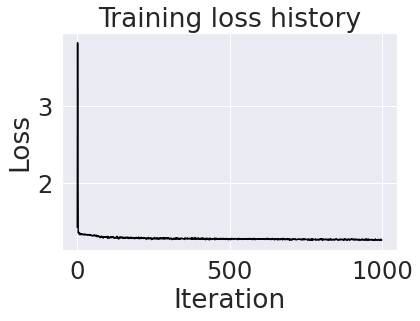

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------- fold 1
(Epoch 0 / 1000) loss: 1.4252 time per epoch: 0.1s
(Epoch 100 / 1000) loss: 1.2942 time per epoch: 0.1s
(Epoch 200 / 1000) loss: 1.2678 time per epoch: 0.1s
(Epoch 300 / 1000) loss: 1.2543 time per epoch: 0.1s
(Epoch 400 / 1000) loss: 1.2517 time per epoch: 0.1s
(Epoch 500 / 1000) loss: 1.2394 time per epoch: 0.1s
(Epoch 600 / 1000) loss: 1.2238 time per epoch: 0.1s
(Epoch 700 / 1000) loss: 1.2344 time per epoch: 0.1s
(Epoch 800 / 1000) loss: 1.2263 time per epoch: 0.1s
(Epoch 900 / 1000) loss: 1.2211 time per epoch: 0.1s


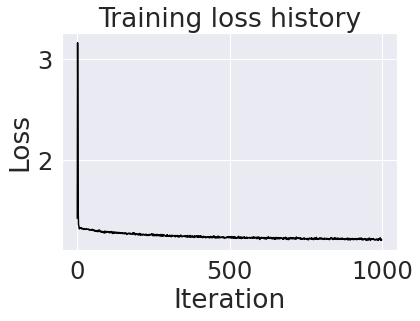

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------- fold 2
(Epoch 0 / 1000) loss: 1.4167 time per epoch: 0.2s
(Epoch 100 / 1000) loss: 1.3224 time per epoch: 0.1s
(Epoch 200 / 1000) loss: 1.3273 time per epoch: 0.1s
(Epoch 300 / 1000) loss: 1.3233 time per epoch: 0.1s
(Epoch 400 / 1000) loss: 1.3206 time per epoch: 0.1s
(Epoch 500 / 1000) loss: 1.2692 time per epoch: 0.1s
(Epoch 600 / 1000) loss: 1.2679 time per epoch: 0.1s
(Epoch 700 / 1000) loss: 1.2658 time per epoch: 0.1s
(Epoch 800 / 1000) loss: 1.2579 time per epoch: 0.1s
(Epoch 900 / 1000) loss: 1.2573 time per epoch: 0.1s


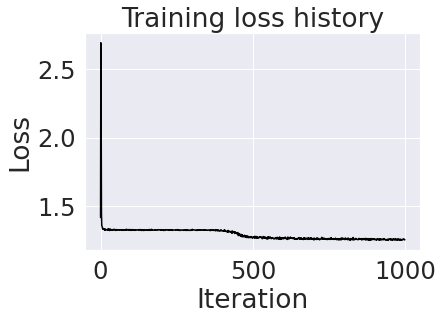

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------- fold 3
(Epoch 0 / 1000) loss: 1.4403 time per epoch: 0.2s
(Epoch 100 / 1000) loss: 1.3273 time per epoch: 0.1s
(Epoch 200 / 1000) loss: 1.3263 time per epoch: 0.1s
(Epoch 300 / 1000) loss: 1.3232 time per epoch: 0.1s
(Epoch 400 / 1000) loss: 1.3226 time per epoch: 0.1s
(Epoch 500 / 1000) loss: 1.2695 time per epoch: 0.1s
(Epoch 600 / 1000) loss: 1.2594 time per epoch: 0.1s
(Epoch 700 / 1000) loss: 1.2447 time per epoch: 0.1s
(Epoch 800 / 1000) loss: 1.2544 time per epoch: 0.1s
(Epoch 900 / 1000) loss: 1.2518 time per epoch: 0.1s


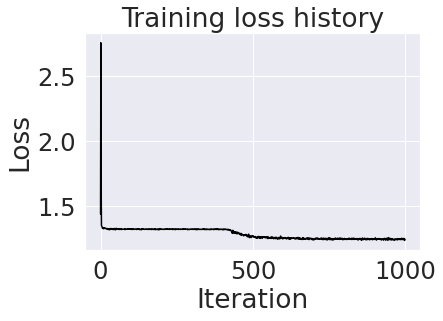

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------- fold 4
(Epoch 0 / 1000) loss: 1.4751 time per epoch: 0.1s
(Epoch 100 / 1000) loss: 1.3202 time per epoch: 0.2s
(Epoch 200 / 1000) loss: 1.3230 time per epoch: 0.2s
(Epoch 300 / 1000) loss: 1.3182 time per epoch: 0.1s
(Epoch 400 / 1000) loss: 1.2752 time per epoch: 0.1s
(Epoch 500 / 1000) loss: 1.2576 time per epoch: 0.1s
(Epoch 600 / 1000) loss: 1.2477 time per epoch: 0.1s
(Epoch 700 / 1000) loss: 1.2434 time per epoch: 0.1s
(Epoch 800 / 1000) loss: 1.2406 time per epoch: 0.2s
(Epoch 900 / 1000) loss: 1.2424 time per epoch: 0.2s


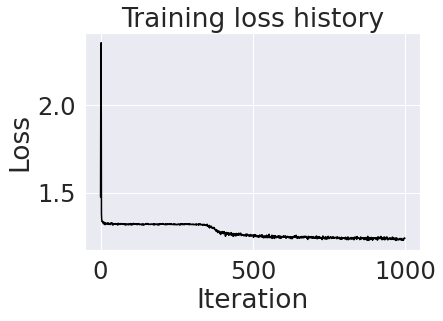

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
num_epochs = 1000
batch_size = 1184 #1184  

conf_Matrix_lstm = np.zeros((4,4),dtype=int) 
accuracy_lstm, precision_lstm, recall_lstm, f1_lstm, Multi_auc_lstm = 0.,0.,0.,0.,0.
for k in range(n_splits): 
  print('--------- fold', k)
  # create the RNN_DNN model
  rnn_dnn_model = RNN_DNN(
          cell_type='lstm',
          input_dim = 3,  #3,     #Seqdata_train.shape[2],  
          input_dim_v = 0, #32,  #Pointdata_train.shape[1], if only consider LSTM, then, 0 
          input_dim_t= 20, #20,   #Seqdata_train.shape[1], 
          proj_dim = 5, #5,   #if only consider DNN, then, 0 
          C=4, 
          hidden_dim = 1, 
          reg = 0.0, 
          dropratio = 0.3, 
          DNN_hidden_Size=[1024, 1024, 2048, 1024, 1024], 
          **to_float_cuda)
  ### training 
  learning_rate = 1e-3 
  ModelTrain(rnn_dnn_model, 
             KFold_data['trainPX'][k], 
             KFold_data['trainSX'][k], 
             KFold_data['trainY'][k],
             num_epochs=num_epochs, batch_size=batch_size,
             learning_rate=learning_rate)
  ### testing 
  rnn_dnn_model = rnn_dnn_model.eval()  
  y_pred_train, loss_train = rnn_dnn_model.test_process(KFold_data['trainPX'][k], KFold_data['trainSX'][k], KFold_data['trainY'][k] )
  y_pred_train, loss_trainfull = y_pred_train.to('cpu') , loss_train.item()
  y_pred_lstm, loss_test= rnn_dnn_model.test_process(KFold_data['testPX'][k], KFold_data['testSX'][k], KFold_data['testY'][k])
  y_pred_lstm, loss_testfull = y_pred_lstm.to('cpu'), loss_test.item()
  
  conf_Matrix_lstm += confusion_matrix(KFold_data['testY'][k], y_pred_lstm)
  accuracy_lstm += accuracy_score(np.array(KFold_data['testY'][k]), y_pred_lstm)/n_splits 
  precision_lstm += precision_score(np.array(KFold_data['testY'][k]), y_pred_lstm, average='weighted')/n_splits  
  recall_lstm += recall_score(np.array(KFold_data['testY'][k]), y_pred_lstm, average='weighted')/n_splits 
  f1_lstm += f1_score(np.array(KFold_data['testY'][k]), y_pred_lstm, average='weighted')/n_splits  
  Multi_auc_lstm += multiclass_roc_auc_score(np.array(KFold_data['testY'][k]),y_pred_lstm)/n_splits 


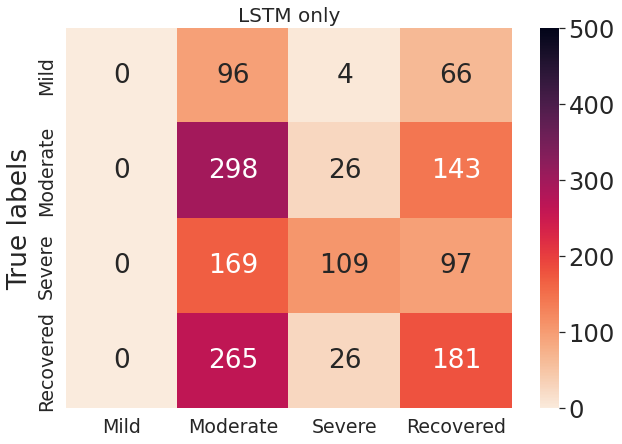

accuracy_score 0.397
precision_score 0.41
recall_score 0.397
f1_score 0.355
Multi_auc 0.556


In [ ]:
sn.set(font_scale=2.2)
plt.figure(figsize = (10,7))
heatmap = sn.heatmap(conf_Matrix_lstm, annot=True, cmap='rocket_r',xticklabels=['Mild','Moderate','Severe','Recovered'],
                     yticklabels=['Mild','Moderate','Severe','Recovered'], vmin=0, vmax=500, fmt="d")
plt.title('LSTM only', fontsize=20)
plt.ylabel("True labels") 
plt.yticks(rotation=90,fontsize=19)
plt.xticks(fontsize=19)
plt.show()        


print("accuracy_score",round(accuracy_lstm,3))
print("precision_score", round(precision_lstm,3))
print("recall_score", round(recall_lstm,3))
print("f1_score", round(f1_lstm,3))
print("Multi_auc",round(Multi_auc_lstm,3))

### Method 5: DNN only

--------- fold 0
(Epoch 0 / 1400) loss: 1.4510 time per epoch: 0.1s
(Epoch 100 / 1400) loss: 0.9618 time per epoch: 0.1s
(Epoch 200 / 1400) loss: 0.8086 time per epoch: 0.1s
(Epoch 300 / 1400) loss: 0.6849 time per epoch: 0.1s
(Epoch 400 / 1400) loss: 0.5953 time per epoch: 0.1s
(Epoch 500 / 1400) loss: 0.5139 time per epoch: 0.1s
(Epoch 600 / 1400) loss: 0.4505 time per epoch: 0.1s
(Epoch 700 / 1400) loss: 0.3725 time per epoch: 0.1s
(Epoch 800 / 1400) loss: 0.3241 time per epoch: 0.1s
(Epoch 900 / 1400) loss: 0.3080 time per epoch: 0.1s
(Epoch 1000 / 1400) loss: 0.2609 time per epoch: 0.1s
(Epoch 1100 / 1400) loss: 0.2147 time per epoch: 0.1s
(Epoch 1200 / 1400) loss: 0.2108 time per epoch: 0.1s
(Epoch 1300 / 1400) loss: 0.1741 time per epoch: 0.1s


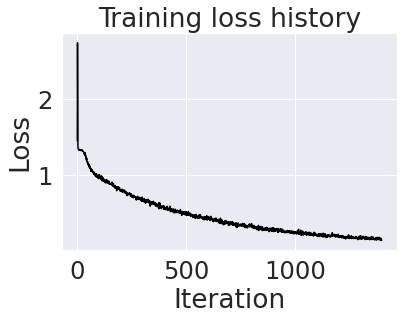

--------- fold 1
(Epoch 0 / 1400) loss: 1.4586 time per epoch: 0.1s
(Epoch 100 / 1400) loss: 0.9623 time per epoch: 0.1s
(Epoch 200 / 1400) loss: 0.8472 time per epoch: 0.1s
(Epoch 300 / 1400) loss: 0.7059 time per epoch: 0.1s
(Epoch 400 / 1400) loss: 0.6129 time per epoch: 0.1s
(Epoch 500 / 1400) loss: 0.5563 time per epoch: 0.1s
(Epoch 600 / 1400) loss: 0.4552 time per epoch: 0.1s
(Epoch 700 / 1400) loss: 0.3883 time per epoch: 0.1s
(Epoch 800 / 1400) loss: 0.3617 time per epoch: 0.1s
(Epoch 900 / 1400) loss: 0.3189 time per epoch: 0.1s
(Epoch 1000 / 1400) loss: 0.2631 time per epoch: 0.1s
(Epoch 1100 / 1400) loss: 0.2413 time per epoch: 0.1s
(Epoch 1200 / 1400) loss: 0.2169 time per epoch: 0.1s
(Epoch 1300 / 1400) loss: 0.1964 time per epoch: 0.1s


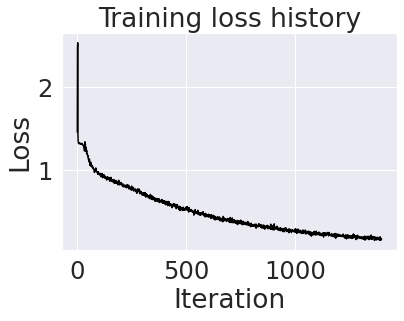

--------- fold 2
(Epoch 0 / 1400) loss: 1.4232 time per epoch: 0.1s
(Epoch 100 / 1400) loss: 0.9790 time per epoch: 0.1s
(Epoch 200 / 1400) loss: 0.8144 time per epoch: 0.1s
(Epoch 300 / 1400) loss: 0.7213 time per epoch: 0.1s
(Epoch 400 / 1400) loss: 0.6008 time per epoch: 0.1s
(Epoch 500 / 1400) loss: 0.5320 time per epoch: 0.1s
(Epoch 600 / 1400) loss: 0.4569 time per epoch: 0.1s
(Epoch 700 / 1400) loss: 0.3695 time per epoch: 0.1s
(Epoch 800 / 1400) loss: 0.3344 time per epoch: 0.1s
(Epoch 900 / 1400) loss: 0.2929 time per epoch: 0.1s
(Epoch 1000 / 1400) loss: 0.2652 time per epoch: 0.1s
(Epoch 1100 / 1400) loss: 0.2330 time per epoch: 0.1s
(Epoch 1200 / 1400) loss: 0.1889 time per epoch: 0.1s
(Epoch 1300 / 1400) loss: 0.1878 time per epoch: 0.1s


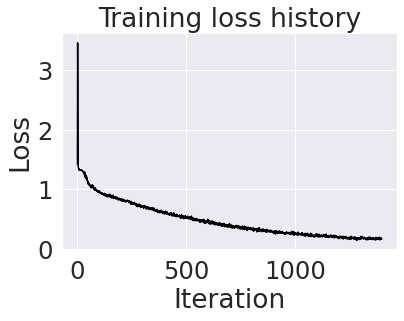

--------- fold 3
(Epoch 0 / 1400) loss: 1.4117 time per epoch: 0.1s
(Epoch 100 / 1400) loss: 0.9700 time per epoch: 0.1s
(Epoch 200 / 1400) loss: 0.8471 time per epoch: 0.1s
(Epoch 300 / 1400) loss: 0.6890 time per epoch: 0.1s
(Epoch 400 / 1400) loss: 0.6068 time per epoch: 0.1s
(Epoch 500 / 1400) loss: 0.5139 time per epoch: 0.1s
(Epoch 600 / 1400) loss: 0.4327 time per epoch: 0.1s
(Epoch 700 / 1400) loss: 0.3714 time per epoch: 0.1s
(Epoch 800 / 1400) loss: 0.3136 time per epoch: 0.1s
(Epoch 900 / 1400) loss: 0.3112 time per epoch: 0.1s
(Epoch 1000 / 1400) loss: 0.2611 time per epoch: 0.1s
(Epoch 1100 / 1400) loss: 0.2259 time per epoch: 0.1s
(Epoch 1200 / 1400) loss: 0.1959 time per epoch: 0.1s
(Epoch 1300 / 1400) loss: 0.1844 time per epoch: 0.1s


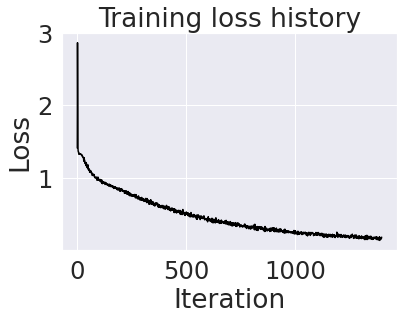

--------- fold 4
(Epoch 0 / 1400) loss: 1.4745 time per epoch: 0.1s
(Epoch 100 / 1400) loss: 0.9506 time per epoch: 0.1s
(Epoch 200 / 1400) loss: 0.8201 time per epoch: 0.1s
(Epoch 300 / 1400) loss: 0.6672 time per epoch: 0.1s
(Epoch 400 / 1400) loss: 0.5628 time per epoch: 0.1s
(Epoch 500 / 1400) loss: 0.5007 time per epoch: 0.1s
(Epoch 600 / 1400) loss: 0.4033 time per epoch: 0.1s
(Epoch 700 / 1400) loss: 0.3381 time per epoch: 0.1s
(Epoch 800 / 1400) loss: 0.3152 time per epoch: 0.1s
(Epoch 900 / 1400) loss: 0.2580 time per epoch: 0.1s
(Epoch 1000 / 1400) loss: 0.2484 time per epoch: 0.1s
(Epoch 1100 / 1400) loss: 0.2201 time per epoch: 0.1s
(Epoch 1200 / 1400) loss: 0.2112 time per epoch: 0.1s
(Epoch 1300 / 1400) loss: 0.1531 time per epoch: 0.1s


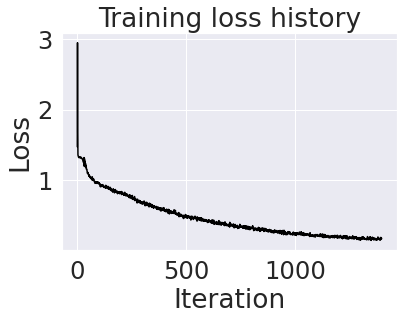

In [ ]:
num_epochs = 1400
batch_size = 1184 #1184  

conf_Matrix_dnn = np.zeros((4,4),dtype=int) 
accuracy_dnn, precision_dnn, recall_dnn, f1_dnn, Multi_auc_dnn = 0.,0.,0.,0.,0.
for k in range(n_splits): 
  print('--------- fold', k)
  # create the RNN_DNN model
  rnn_dnn_model = RNN_DNN(
          cell_type='lstm',
          input_dim = 3,  #3,     #Seqdata_train.shape[2],  
          input_dim_v = 32, #32,  #Pointdata_train.shape[1], if only consider LSTM, then, 0 
          input_dim_t= 20, #20,   #Seqdata_train.shape[1], 
          proj_dim = 0, #5,   #if only consider DNN, then, 0 
          C=4, 
          hidden_dim = 1, 
          reg = 0.0, 
          dropratio = 0.3,  #0.3
          DNN_hidden_Size=[1024, 1024, 2048, 1024, 1024], 
          **to_float_cuda)
  ### training 
  learning_rate = 1e-3 
  ModelTrain(rnn_dnn_model, 
             KFold_data['trainPX'][k], 
             KFold_data['trainSX'][k], 
             KFold_data['trainY'][k],
             lr_decay = 1, 
             num_epochs=num_epochs, batch_size=batch_size,
             learning_rate=learning_rate)
  ### testing 
  rnn_dnn_model = rnn_dnn_model.eval()  
  y_pred_train, loss_train = rnn_dnn_model.test_process(KFold_data['trainPX'][k], KFold_data['trainSX'][k], KFold_data['trainY'][k] )
  y_pred_train, loss_trainfull = y_pred_train.to('cpu') , loss_train.item()
  y_pred_dnn, loss_test= rnn_dnn_model.test_process(KFold_data['testPX'][k], KFold_data['testSX'][k], KFold_data['testY'][k])
  y_pred_dnn, loss_testfull = y_pred_dnn.to('cpu'), loss_test.item()
  
  conf_Matrix_dnn += confusion_matrix(KFold_data['testY'][k], y_pred_dnn)
  accuracy_dnn += accuracy_score(np.array(KFold_data['testY'][k]), y_pred_dnn)/n_splits 
  precision_dnn += precision_score(np.array(KFold_data['testY'][k]), y_pred_dnn, average='weighted')/n_splits  
  recall_dnn += recall_score(np.array(KFold_data['testY'][k]), y_pred_dnn, average='weighted')/n_splits 
  f1_dnn += f1_score(np.array(KFold_data['testY'][k]), y_pred_dnn, average='weighted')/n_splits  
  Multi_auc_dnn += multiclass_roc_auc_score(np.array(KFold_data['testY'][k]),y_pred_dnn)/n_splits 


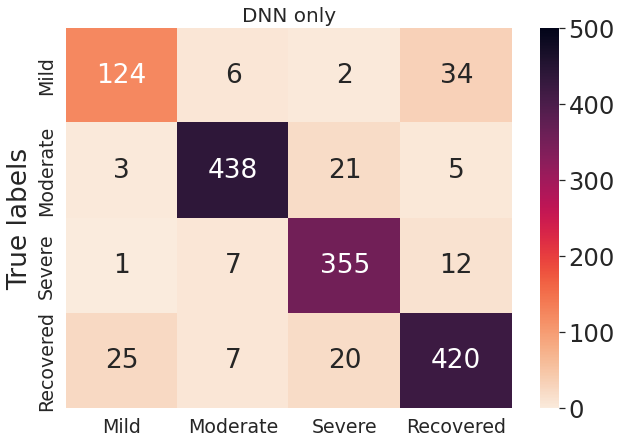

accuracy_score 0.903
precision_score 0.905
recall_score 0.903
f1_score 0.903
Multi_auc 0.924


In [ ]:
sn.set(font_scale=2.2)
plt.figure(figsize = (10,7))
heatmap = sn.heatmap(conf_Matrix_dnn, annot=True, cmap='rocket_r',xticklabels=['Mild','Moderate','Severe','Recovered'],
                     yticklabels=['Mild','Moderate','Severe','Recovered'],vmin=0, vmax=500,fmt="d")
plt.title('DNN only', fontsize=20)
plt.ylabel("True labels") 
plt.yticks(rotation=90,fontsize=19)
plt.xticks(fontsize=19)
plt.show()

print("accuracy_score",round(accuracy_dnn,3))
print("precision_score", round(precision_dnn,3))
print("recall_score", round(recall_dnn,3))
print("f1_score", round(f1_dnn,3))
print("Multi_auc",round(Multi_auc_dnn,3))

### Method 6: Our model LSTM+DNN 

--------- fold 0
(Epoch 0 / 1400) loss: 1.4037 time per epoch: 0.3s
(Epoch 100 / 1400) loss: 1.0041 time per epoch: 0.1s
(Epoch 200 / 1400) loss: 0.8508 time per epoch: 0.1s
(Epoch 300 / 1400) loss: 0.7072 time per epoch: 0.1s
(Epoch 400 / 1400) loss: 0.6058 time per epoch: 0.1s
(Epoch 500 / 1400) loss: 0.5105 time per epoch: 0.1s
(Epoch 600 / 1400) loss: 0.4411 time per epoch: 0.1s
(Epoch 700 / 1400) loss: 0.3830 time per epoch: 0.1s
(Epoch 800 / 1400) loss: 0.3236 time per epoch: 0.1s
(Epoch 900 / 1400) loss: 0.2963 time per epoch: 0.1s
(Epoch 1000 / 1400) loss: 0.2465 time per epoch: 0.1s
(Epoch 1100 / 1400) loss: 0.2278 time per epoch: 0.1s
(Epoch 1200 / 1400) loss: 0.2093 time per epoch: 0.1s
(Epoch 1300 / 1400) loss: 0.1683 time per epoch: 0.1s


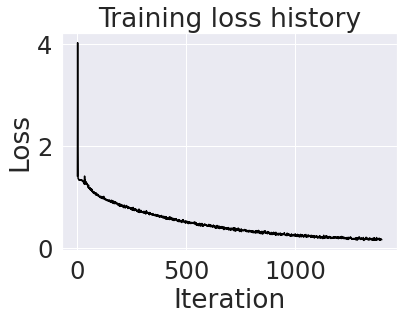

--------- fold 1
(Epoch 0 / 1400) loss: 1.4237 time per epoch: 0.1s
(Epoch 100 / 1400) loss: 0.9607 time per epoch: 0.1s
(Epoch 200 / 1400) loss: 0.8364 time per epoch: 0.1s
(Epoch 300 / 1400) loss: 0.7291 time per epoch: 0.1s
(Epoch 400 / 1400) loss: 0.6274 time per epoch: 0.1s
(Epoch 500 / 1400) loss: 0.5244 time per epoch: 0.2s
(Epoch 600 / 1400) loss: 0.4285 time per epoch: 0.1s
(Epoch 700 / 1400) loss: 0.3702 time per epoch: 0.1s
(Epoch 800 / 1400) loss: 0.3278 time per epoch: 0.1s
(Epoch 900 / 1400) loss: 0.2858 time per epoch: 0.1s
(Epoch 1000 / 1400) loss: 0.2474 time per epoch: 0.1s
(Epoch 1100 / 1400) loss: 0.1994 time per epoch: 0.1s
(Epoch 1200 / 1400) loss: 0.1903 time per epoch: 0.1s
(Epoch 1300 / 1400) loss: 0.1803 time per epoch: 0.1s


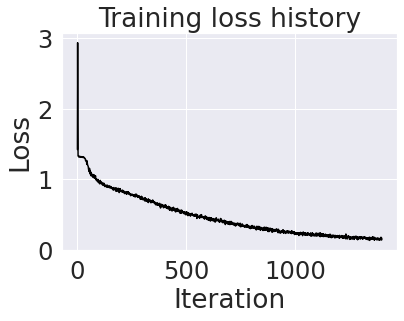

--------- fold 2
(Epoch 0 / 1400) loss: 1.3749 time per epoch: 0.1s
(Epoch 100 / 1400) loss: 0.9572 time per epoch: 0.1s
(Epoch 200 / 1400) loss: 0.8250 time per epoch: 0.1s
(Epoch 300 / 1400) loss: 0.6992 time per epoch: 0.1s
(Epoch 400 / 1400) loss: 0.5922 time per epoch: 0.2s
(Epoch 500 / 1400) loss: 0.4667 time per epoch: 0.1s
(Epoch 600 / 1400) loss: 0.4316 time per epoch: 0.1s
(Epoch 700 / 1400) loss: 0.3423 time per epoch: 0.1s
(Epoch 800 / 1400) loss: 0.2667 time per epoch: 0.1s
(Epoch 900 / 1400) loss: 0.2775 time per epoch: 0.1s
(Epoch 1000 / 1400) loss: 0.2349 time per epoch: 0.1s
(Epoch 1100 / 1400) loss: 0.1823 time per epoch: 0.1s
(Epoch 1200 / 1400) loss: 0.1918 time per epoch: 0.1s
(Epoch 1300 / 1400) loss: 0.1593 time per epoch: 0.1s


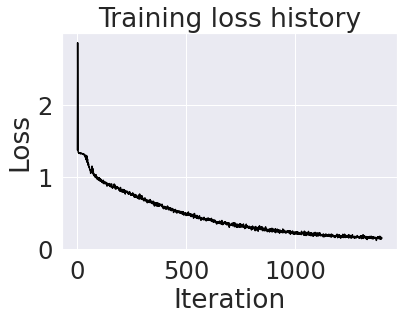

--------- fold 3
(Epoch 0 / 1400) loss: 1.4144 time per epoch: 0.1s
(Epoch 100 / 1400) loss: 0.9876 time per epoch: 0.2s
(Epoch 200 / 1400) loss: 0.8430 time per epoch: 0.1s
(Epoch 300 / 1400) loss: 0.7238 time per epoch: 0.1s
(Epoch 400 / 1400) loss: 0.5714 time per epoch: 0.1s
(Epoch 500 / 1400) loss: 0.5002 time per epoch: 0.1s
(Epoch 600 / 1400) loss: 0.4164 time per epoch: 0.1s
(Epoch 700 / 1400) loss: 0.3598 time per epoch: 0.1s
(Epoch 800 / 1400) loss: 0.3120 time per epoch: 0.1s
(Epoch 900 / 1400) loss: 0.2671 time per epoch: 0.1s
(Epoch 1000 / 1400) loss: 0.2687 time per epoch: 0.2s
(Epoch 1100 / 1400) loss: 0.2142 time per epoch: 0.1s
(Epoch 1200 / 1400) loss: 0.1706 time per epoch: 0.1s
(Epoch 1300 / 1400) loss: 0.1866 time per epoch: 0.2s


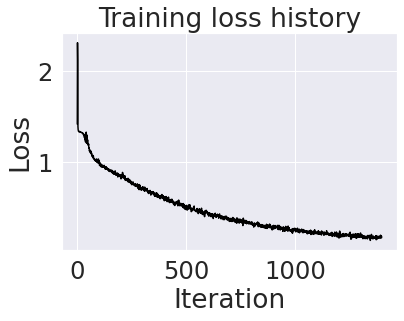

--------- fold 4
(Epoch 0 / 1400) loss: 1.3910 time per epoch: 0.1s
(Epoch 100 / 1400) loss: 0.9641 time per epoch: 0.1s
(Epoch 200 / 1400) loss: 0.8462 time per epoch: 0.1s
(Epoch 300 / 1400) loss: 0.7421 time per epoch: 0.1s
(Epoch 400 / 1400) loss: 0.5974 time per epoch: 0.1s
(Epoch 500 / 1400) loss: 0.4838 time per epoch: 0.1s
(Epoch 600 / 1400) loss: 0.4332 time per epoch: 0.1s
(Epoch 700 / 1400) loss: 0.3668 time per epoch: 0.2s
(Epoch 800 / 1400) loss: 0.3153 time per epoch: 0.1s
(Epoch 900 / 1400) loss: 0.2707 time per epoch: 0.2s
(Epoch 1000 / 1400) loss: 0.2471 time per epoch: 0.1s
(Epoch 1100 / 1400) loss: 0.2171 time per epoch: 0.1s
(Epoch 1200 / 1400) loss: 0.1950 time per epoch: 0.1s
(Epoch 1300 / 1400) loss: 0.1764 time per epoch: 0.1s


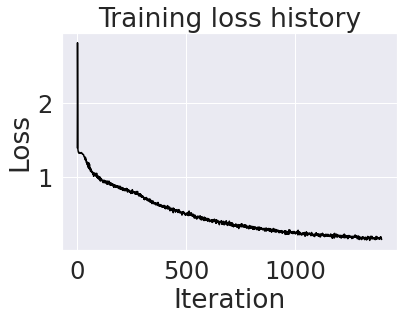

In [ ]:
num_epochs = 1400
batch_size = 1184 #1184  

conf_Matrix_LD = np.zeros((4,4),dtype=int) 
accuracy_LD, precision_LD, recall_LD, f1_LD, Multi_auc_LD = 0.,0.,0.,0.,0.
for k in range(n_splits): 
  print('--------- fold', k)
  # create the RNN_DNN model
  rnn_dnn_model = RNN_DNN(
          cell_type='lstm',
          input_dim = 3,  #3,     #Seqdata_train.shape[2],  
          input_dim_v = 32, #32,  #Pointdata_train.shape[1], if only consider LSTM, then, 0 
          input_dim_t= 20, #20,   #Seqdata_train.shape[1], 
          proj_dim = 5, #5,   #if only consider DNN, then, 0 
          C=4, 
          hidden_dim = 1, 
          reg = 0.0, 
          dropratio = 0.3, #0.3
          DNN_hidden_Size=[1024, 1024, 2048, 1024, 1024], 
          **to_float_cuda)
  ### training 
  learning_rate = 1e-3 
  ModelTrain(rnn_dnn_model, 
             KFold_data['trainPX'][k], 
             KFold_data['trainSX'][k], 
             KFold_data['trainY'][k],
             lr_decay= 1, 
             num_epochs=num_epochs, batch_size=batch_size,
             learning_rate=learning_rate)
  ### testing 
  rnn_dnn_model = rnn_dnn_model.eval()  
  y_pred_train, loss_train = rnn_dnn_model.test_process(KFold_data['trainPX'][k], KFold_data['trainSX'][k], KFold_data['trainY'][k] )
  y_pred_train, loss_trainfull = y_pred_train.to('cpu') , loss_train.item()
  y_pred_LD, loss_test= rnn_dnn_model.test_process(KFold_data['testPX'][k], KFold_data['testSX'][k], KFold_data['testY'][k])
  y_pred_LD, loss_testfull = y_pred_LD.to('cpu'), loss_test.item()
  
  conf_Matrix_LD += confusion_matrix(KFold_data['testY'][k], y_pred_LD)
  accuracy_LD += accuracy_score(np.array(KFold_data['testY'][k]), y_pred_LD)/n_splits 
  precision_LD += precision_score(np.array(KFold_data['testY'][k]), y_pred_LD, average='weighted')/n_splits  
  recall_LD += recall_score(np.array(KFold_data['testY'][k]), y_pred_LD, average='weighted')/n_splits 
  f1_LD += f1_score(np.array(KFold_data['testY'][k]), y_pred_LD, average='weighted')/n_splits  
  Multi_auc_LD += multiclass_roc_auc_score(np.array(KFold_data['testY'][k]),y_pred_LD)/n_splits 


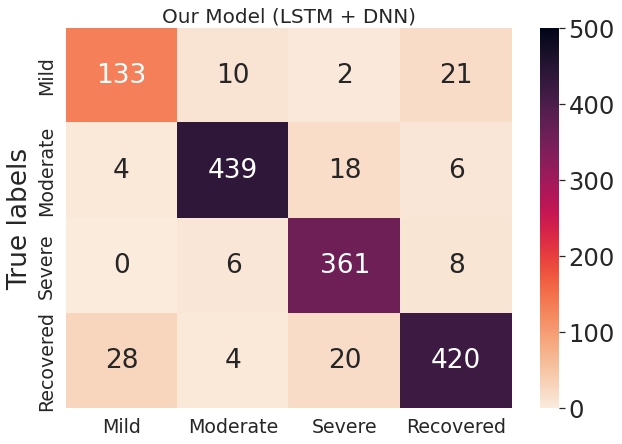

accuracy_score 0.914
precision_score 0.917
recall_score 0.914
f1_score 0.914
Multi_auc 0.935


In [ ]:
sn.set(font_scale=2.2)
plt.figure(figsize = (10,7))
heatmap = sn.heatmap(conf_Matrix_LD, annot=True, cmap='rocket_r',xticklabels=['Mild','Moderate','Severe','Recovered'],
                     yticklabels=['Mild','Moderate','Severe','Recovered'],vmin=0, vmax=500,fmt="d")
plt.title('Our Model (LSTM + DNN)', fontsize=20)
plt.ylabel("True labels") 
plt.yticks(rotation=90,fontsize=19)
plt.xticks(fontsize=19)
plt.show()

print("accuracy_score",round(accuracy_LD,3))
print("precision_score", round(precision_LD,3))
print("recall_score", round(recall_LD,3))
print("f1_score", round(f1_LD,3))
print("Multi_auc",round(Multi_auc_LD,3))